In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.5, 0.5],
    c1 = 2.0,
    c2 = 2.0,
    w = 0.8,
    w_decay = 0.95,
    scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


Checkpoint 100, Accuracy: 0.8518518518518519, Loss: 0.5826880490338361
Checkpoint 200, Accuracy: 0.8518518518518519, Loss: 0.5826880490338361
Checkpoint 300, Accuracy: 0.8518518518518519, Loss: 0.5826880490338361
Checkpoint 400, Accuracy: 0.8703703703703703, Loss: 0.5667299341272425
Checkpoint 500, Accuracy: 0.8703703703703703, Loss: 0.5591347659075702


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None and title is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

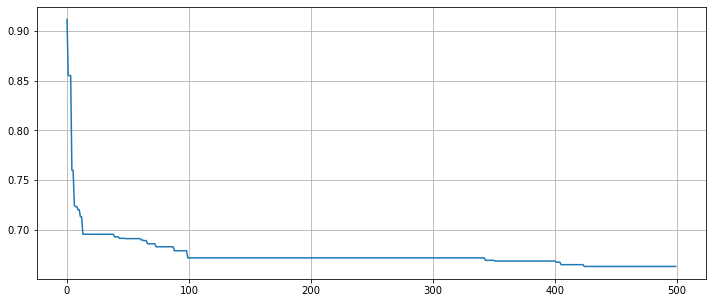

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.9157803 ]
 [0.06473137]
 [0.01948834]]
[1. 0. 0.] <-> [[0.9110073 ]
 [0.06299289]
 [0.02599989]]
[1. 0. 0.] <-> [[0.48933026]
 [0.29683572]
 [0.21383403]]
[0. 1. 0.] <-> [[0.13728729]
 [0.3939349 ]
 [0.4687778 ]]
[1. 0. 0.] <-> [[0.9159009 ]
 [0.06551633]
 [0.01858275]]
[0. 0. 1.] <-> [[0.11717208]
 [0.3912096 ]
 [0.49161837]]
[0. 0. 1.] <-> [[0.39196926]
 [0.33930838]
 [0.26872233]]
[0. 1. 0.] <-> [[0.45189255]
 [0.31444734]
 [0.23366009]]
[1. 0. 0.] <-> [[0.91477627]
 [0.06395531]
 [0.0212684 ]]
[1. 0. 0.] <-> [[0.9044297 ]
 [0.06216803]
 [0.03340232]]
[1. 0. 0.] <-> [[0.90746576]
 [0.06250948]
 [0.03002485]]
[0. 1. 0.] <-> [[0.08626664]
 [0.38141677]
 [0.5323166 ]]
[0. 0. 1.] <-> [[0.13484257]
 [0.39371794]
 [0.47143945]]
[1. 0. 0.] <-> [[0.450555  ]
 [0.31504345]
 [0.2344015 ]]
[0. 1. 0.] <-> [[0.15417756]
 [0.3947124 ]
 [0.45111006]]
[1. 0. 0.] <-> [[0.52324134]
 [0.2788273 ]
 [0.19793138]]
[1. 0. 0.] <-> [[0.9138152 ]
 [0.06830285]
 [0.01788191]]
[1. 0. 0.] <->

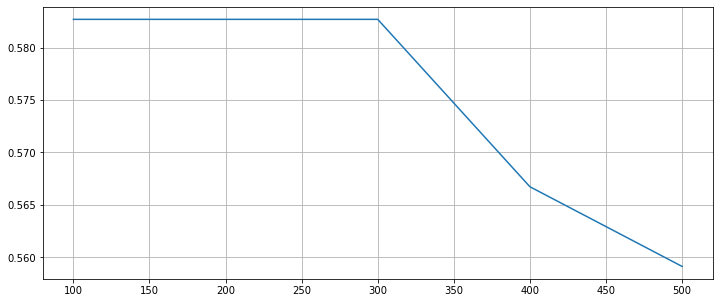

In [12]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

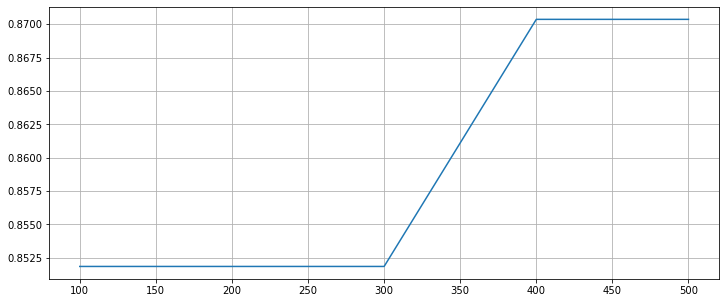

In [13]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[[ 0.690563 ]
 [-3.       ]
 [ 3.       ]
 [-1.6183136]
 [-0.5331043]]
 bias: [-1.7180011]

Neuron 1: weights:
[[ 0.95217824]
 [-2.1320167 ]
 [-2.915703  ]
 [-2.716524  ]
 [-1.8758067 ]]
 bias: [-1.59055]

Neuron 2: weights:
[[ 1.4259802 ]
 [-2.8512034 ]
 [-0.68213725]
 [-0.4773927 ]
 [ 3.        ]]
 bias: [-0.77736974]

Neuron 3: weights:
[[-0.20263132]
 [-1.0811276 ]
 [ 0.9371783 ]
 [-2.0504313 ]
 [ 1.4372672 ]]
 bias: [2.4550507]

$
Layer 2
Neuron 0: weights:
[[-0.9072627 ]
 [ 0.05775175]
 [-0.6056561 ]
 [ 3.        ]]
 bias: [-2.3887706]

Neuron 1: weights:
[[-0.5784497 ]
 [-1.6385801 ]
 [ 0.52048564]
 [ 0.10112517]]
 bias: [-0.9513538]

Neuron 2: weights:
[[ 1.7611424 ]
 [-3.        ]
 [ 2.161531  ]
 [-0.42295092]]
 bias: [-1.6094247]

$

